In [15]:
''' Generates csv with mean and standard deviation of potential crack
 intensities and gradients'''

# Setup
import csv
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [16]:
# Dataset Load function
# Selects and greyscales 100 negative and positive images

# REMEMBER THE PATH 
def get_train_data(nsamples=100):

    data_pos = [cv2.cvtColor(cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000))), cv2.COLOR_BGR2GRAY) for i in range(nsamples)]

    data_neg = [cv2.cvtColor(cv2.imread("C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000))), cv2.COLOR_BGR2GRAY) for i in range(nsamples)]

    return data_pos, data_neg

In [17]:
# Calculates and returns mean and standard deviation for all images.
def mean_int(im, im_bin, key):
    (h,w) = im.shape
    (mean, stdev) = (0, 0)
    vals = []
    for i in range(h):
        for j in range(w):
            if im_bin[i,j] == key:
                vals.append(im[i,j])
                
    mean = sum(vals) / len(vals)   
    try:
        stdev = sum([abs(x - mean) for x in vals]) / len(vals)
    except ZeroDivisionError:
        stdev = 'NaN'

    return mean, stdev

In [18]:
def find_limits(img, lb, ub):
    w, h = img.shape
    im_arr = np.reshape(img, (w*h))
    
    im_arr = np.sort(im_arr)
    
    i_a = int(round(w*h * lb, 0))
    i_b = int(round(w*h * ub, 0))
    
    a = im_arr[i_a-1]
    b = im_arr[i_b-1]
    
    t = find_t(im_arr, i_a, i_b)
    
    return a, b, t

def find_t(arr, ia, ib):
    a, b = arr[ia], arr[ib]
    
    interval = arr[ia:ib+1]
    mean_i = sum(interval) / len(interval)
    
    t = (2*mean_i*(b - a)) / (255*(a+b))
    
    return t

def nl_grayscale(img, lb, ub):
    '''
    Non-linear grayscale transformation
    '''
    new_a = 0
    new_b = 255
    a, b, t = find_limits(img, lb, ub)
    w, h = img.shape
    

    im_out = img.copy()
    
    i = img<a
    im_out[i] = new_a
    
    i = img > b
    im_out[i] = new_b
    
    
    for i in range(w):
        for j in range(h):
            if img[i, j] < a and not img[i, j] > b:
                new_a + ((new_a - new_b) / (a**t - b**t)) * (img[i, j]**t - a**t)
                
                
    #im_out[not img<b] = new_b
    #im_out[img<a and not img<b] = new_a
    
    return im_out


In [5]:
def improved_otsu(img, thresh, ksize=7):
    '''
    Improved Otsu's Method
    '''

    w, h = img.shape
    x = ksize // 2
    y = ksize // 2
    im_out = img.copy()
    
    # STEP 1 -> 3
    
    while not x > w:
        while y < (h - ksize // 2):
            
            if not x == w:
                window = img[(x-3):(x+4),(y-3):(y+4)]
            else:
                window = img[(x-3):x,(y-3):(y+4)]
                
            var = window.std()
            

            if var < thresh:
                new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
            else:
                new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                
                
            if not x == w:
                im_out[(x-3):(x+4),(y-3):(y+4)] = seg_window
            else:
                im_out[(x-3):x,(y-3):(y+4)] = seg_window
                
            y += ksize
            
            #m = window.mean()
            #var = sum([(i - m) ** 2 for i in window]) / ksize**2
            #var = sum([sum([ (i[j] - m) ** 2 for j in range(7)]) for i in window])/ 7 ** 2
            
            #print(var)
            #print((x-3), (x+4), y-3, y+4)
        
        if not x == w:
            window = img[(x-3):(x+4),(y-3):y]
        else:
            window = img[(x-3):x,(y-3):y]
            
        var = window.std()
        
        if var < thresh:
            new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
        else:
            new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        if not x == w:
            im_out[(x-3):(x+4),(y-3):y] = seg_window
        else:
            im_out[(x-3):x,(y-3):y] = seg_window
            
        x += ksize
        y = ksize // 2
    
    window = img[(x-3):x,(y-3):(y+4)]
    var = window.std()
    if var < thresh:
        new_thresh, seg_window = cv2.threshold(window, thresh, 255, cv2.THRESH_BINARY_INV)
    else:
        new_thresh, seg_window = cv2.threshold(window, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    im_out[(x-3):x,(y-3):(y+4)] = seg_window
    
    # Step 4
    
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
#     im_out = cv2.dilate(im_out, kernel, iterations = 1)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#     im_out = cv2.erode(im_out, kernel, iterations = 1)
    
#     blur = cv2.medianBlur(im_out, 5)

    
    return im_out

In [63]:
SAMPLE_SIZE = 500
pos, neg = get_train_data(SAMPLE_SIZE)

In [7]:
# PIPELINE: 
# Linear Grayscale -> Otsu's method + Inv. binary threshold (0, 255) -> Erosion (7x7)

# blur_pos = [cv2.GaussianBlur(pos[i], (7, 7), 0) for i in range(SAMPLE_SIZE)]
# out = [cv2.threshold(blur_pos[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]

# thres_val_pos = [out[i][0] for i in range(SAMPLE_SIZE)]
# thresh_pos = [np.bitwise_not(out[i][1]) for i in range(SAMPLE_SIZE)]

# blur_neg = [cv2.GaussianBlur(neg[i], (7, 7), 0) for i in range(SAMPLE_SIZE)]
# out = [cv2.threshold(blur_neg[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]

# thres_val_neg = [out[i][0] for i in range(SAMPLE_SIZE)]
# thresh_neg = [np.bitwise_not(out[i][1]) for i in range(SAMPLE_SIZE)]

# kernel = np.ones((7, 7), np.uint8)
# erosion_pos = [cv2.erode(thresh_pos[i], kernel, iterations=1) for i in range(SAMPLE_SIZE)]
# erosion_neg = [cv2.erode(thresh_neg[i], kernel, iterations=1) for i in range(SAMPLE_SIZE)]

In [64]:
# PIPELINE: 
# Median Blur (3x3) -> Non-linear grayscale (adaptive upper bound) -> Improved Otsu's w/ bias

blur_pos = [cv2.medianBlur(pos[i], 3) for i in range(SAMPLE_SIZE)]
out = [cv2.threshold(blur_pos[i], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]
# thres_val_pos = [out[i][0] for i in range(SAMPLE_SIZE)] # Only contains threshold values
thresh_pos = [out[i][1] for i in range(SAMPLE_SIZE)]

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
open_pos = [cv2.morphologyEx(thresh_pos[i], cv2.MORPH_OPEN, kernel) for i in range(SAMPLE_SIZE)]

upper_bound_pos = [round(np.count_nonzero(open_pos[i])/(227*227), 4) for i in range(SAMPLE_SIZE)]
nl_pos = [nl_grayscale(blur_pos[i], 0.02, val+0.05) for i, val in enumerate(upper_bound_pos)]
#print(len(nl_pos))

out = [cv2.threshold(nl_pos[i], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]
nl_thres_val_pos = [out[i][0] for i in range(SAMPLE_SIZE)] # Only contains threshold values
print("Shitton of stuff done, just ignore warnings")

imp_otsu_pos = [improved_otsu(nl_pos[i], val-20) for i, val in enumerate(nl_thres_val_pos)]
print("Improved Otsu done, just ignore warnings")

#------------------------------------------------------------------------------------------------------------------------

blur_neg = [cv2.medianBlur(neg[i], 3) for i in range(SAMPLE_SIZE)]
out = [cv2.threshold(blur_neg[i], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]

thres_val_neg = [out[i][0] for i in range(SAMPLE_SIZE)]
thresh_neg = [out[i][1] for i in range(SAMPLE_SIZE)]

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
open_neg = [cv2.morphologyEx(thresh_neg[i], cv2.MORPH_OPEN, kernel) for i in range(SAMPLE_SIZE)]

upper_bound_neg = [round(np.count_nonzero(open_neg[i])/(227*227), 4) for i in range(SAMPLE_SIZE)]

nl_neg = [nl_grayscale(blur_neg[i], 0.02, val+0.05) for i, val in enumerate(upper_bound_neg)]
out = [cv2.threshold(nl_neg[i], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) for i in range(SAMPLE_SIZE)]
nl_thres_val_neg = [out[i][0] for i in range(SAMPLE_SIZE)] # Only contains threshold values
print("Shitton of stuff done, just ignore warnings")

imp_otsu_neg = [improved_otsu(nl_neg[i], val-20) for i, val in enumerate(nl_thres_val_neg)]
print("Improved Otsu done, just ignore warnings")



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


Shitton of stuff done, just ignore warnings


C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Rasmus\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Improved Otsu done, just ignore warnings
Shitton of stuff done, just ignore warnings
Improved Otsu done, just ignore warnings


In [65]:
cv2.imshow("Crack Ori", pos[8])
cv2.imshow("No Crack Ori", neg[8])

cv2.imshow("Crack", imp_otsu_pos[8])
cv2.imshow("No Crack", imp_otsu_neg[8])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [66]:
intens_mean_pos = []
intens_std_pos = []
intens_mean_neg = []
intens_std_neg = []

for i in range(SAMPLE_SIZE):
    # Positive
    m, st = mean_int(pos[i], imp_otsu_pos[i], 255)
    intens_mean_pos.append(m)
    intens_std_pos.append(st)
    
    # Negative
    m, st = mean_int(neg[i], imp_otsu_pos[i], 255)
    intens_mean_neg.append(m)
    intens_std_neg.append(st)

result_mean = np.concatenate((intens_mean_pos, intens_mean_neg),0)
result_stdev = np.concatenate((intens_std_pos, intens_std_neg),0)

In [67]:
gauss_pos = [cv2.GaussianBlur(pos[i], (5,5), 0) for i in range(SAMPLE_SIZE)]
gauss_neg = [cv2.GaussianBlur(neg[i], (5,5), 0) for i in range(SAMPLE_SIZE)]

lap_pos = [cv2.Laplacian(gauss_pos[i], cv2.CV_64F) for i in range(SAMPLE_SIZE)]
lap_neg = [cv2.Laplacian(gauss_neg[i], cv2.CV_64F) for i in range(SAMPLE_SIZE)]

In [68]:
print(len(lap_pos[1]))

227


In [69]:
grad_mean_pos = []
grad_std_pos = []
grad_mean_neg = []
grad_std_neg = []

for i in range(SAMPLE_SIZE):
    # Positive
    m, st = mean_int(lap_pos[i], imp_otsu_pos[i], 255)
    grad_mean_pos.append(m)
    grad_std_pos.append(st)
    
    # Negative
    m, st = mean_int(lap_neg[i], imp_otsu_pos[i], 255)
    grad_mean_neg.append(m)
    grad_std_neg.append(st)

result_mean_grad = np.concatenate((grad_mean_pos, grad_mean_neg),0)
result_stdev_grad = np.concatenate((grad_std_pos, grad_std_neg),0)

In [70]:
# Create labels
label_neg = np.array(np.zeros(len(intens_mean_pos), dtype = int))
label_pos = np.array(np.ones(len(intens_mean_neg), dtype = int))
labels = np.concatenate((label_pos, label_neg),0)


In [12]:
#labels.astype(str)

In [71]:
# Create dataframe
df = pd.DataFrame(np.column_stack([result_mean, result_stdev, labels]), 
                  index=range(SAMPLE_SIZE*2), 
                  columns=['Mean', 'StDev', 'label']) 

df.head()

,Mean,StDev,label
0,91.289461,20.921652,1.0
1,83.884333,13.256290,1.0
2,104.066036,22.754079,1.0
3,90.049002,22.820437,1.0
4,87.474838,10.641719,1.0


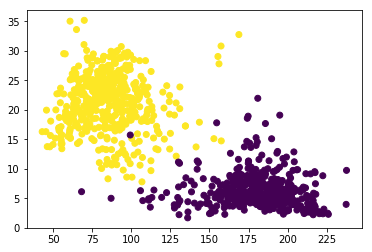

In [72]:
plt.scatter(df.Mean, df.StDev, c=df.label)

In [81]:
print(len(result_mean))
print(len(result_mean_grad))


print(np.unique(lap_neg[2]))
print(np.unique(lap_pos[10]))


1000
1000
[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.
   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  18.  20.]
[-23. -22. -21. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.]


In [73]:
# Create dataframe
df = pd.DataFrame(np.column_stack([result_mean_grad, result_stdev_grad, labels]), 
                  index=range(SAMPLE_SIZE*2), 
                  columns=['GMean', 'GStDev', 'label']) 

df.head()

,GMean,GStDev,label
0,5.226091,6.462550,1.0
1,4.903305,5.925083,1.0
2,2.450651,4.223947,1.0
3,1.907999,4.097862,1.0
4,4.590909,5.267710,1.0


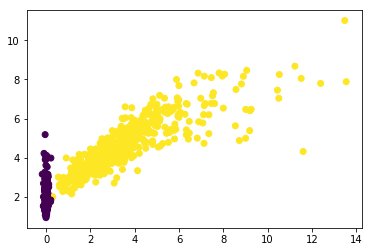

In [74]:
plt.scatter(df.GMean, df.GStDev, c=df.label)

In [ ]:
# Export to .csv
df.to_csv('features_example.csv')